In [1]:
using GaussQuadrature, FastGaussQuadrature, SpecialFunctions, LinearAlgebra, Plots

┌ Info: Recompiling stale cache file C:\Users\Marco\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\GaussQuadrature\qLpu8.ji for GaussQuadrature [d54b0c1a-921d-58e0-8e36-89d8069c0969]
└ @ Base loading.jl:1240
┌ Warning: Package SpecialFunctions does not have Libdl in its dependencies:
│ - If you have SpecialFunctions checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with SpecialFunctions
└ Loading Libdl into SpecialFunctions from project dependency, future warnings for SpecialFunctions are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for GaussQuadrature [d54b0c1a-921d-58e0-8e36-89d8069c0969]
│   exception = ErrorException("Required dependency SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] failed to load from a cache file.")
└ @ Base loading.jl:1025
┌ Info: Recompiling stale cache fi

On the curve $x^4 + y^4 = 1$, use the inner product
$$
\langle f, g \rangle = \int_{-1}^{1} \left[ f(x,y)g(x,y) + f(x,-y)g(x,-y)\right]\mathrm{d}x, \qquad y = \sqrt[4]{1-x^4}.
$$
Note that $\langle x^i, y^j \rangle = 0$ if $i$ or $j$ is odd. For even $i$ and $j$,
$$
\langle x^i, y^j \rangle = 2\int_{-1}^{1} x^i y^j \mathrm{d}x = \frac{(1+(-1)^i)\Gamma(j/4+1)\Gamma(i/4 +1/4)}{2\Gamma(j/4+5/4+i/4)}=
 \mathrm{B}(j/4+1,i/4 +1/4),
$$
thus we have an explicit expression for the moments in terms of the Beta function.

We'll follow the Gram-Schmidt procedure using (i) quadrature and (ii) the formula above for the moments. Due to the instability of the GS-procedure, we use BigFloats:

In [2]:
digits = 200
p = Int64(round(-log(10.0^(-digits))/log(2)+1))
setprecision(p)
eps(BigFloat)

1.306420176630260372014458839381409187692885829284212960763337974781164378711899959012357647219720206961567756086182151119073634759644348205532976426279074776518688729228857922353671951349060138355967699e-200

We'll have to compute inner products/moments of the form $\langle x^i, y^j \rangle$, for $i\geq 0$ and $j = 0, 2, 4, 6$. Some experimentation suggests that the rate of convergence of Gauss-Legendre quadrature for $\langle x^i, y^j \rangle$ is $\mathcal{O}\left(n^{-2-j/2}  \right)$ if $\text{mod}(j,4) \neq 0$. With $1000$ nodes and weights, we only get $6$ digits of accuracy:

In [3]:
n = 1000;
@time x, w = jacobi(n,BigFloat(0),BigFloat(0));

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = jacobi_coefs(::Int64, ::BigFloat, ::BigFloat) at GaussQuadrature.jl:207
└ @ GaussQuadrature C:\Users\Marco\.juliapro\JuliaPro_v1.2.0-1\packages\GaussQuadrature\ncvNj\src\GaussQuadrature.jl:207
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = jacobi_coefs(::Int64, ::BigFloat, ::BigFloat) at GaussQuadrature.jl:207
└ @ GaussQuadrature C:\Users\Marco\.juliapro\JuliaPro_v1.2.0-1\packages\GaussQuadrature\ncvNj\src\GaussQuadrature.jl:207


 19.520138 seconds (150.73 M allocations: 9.730 GiB, 13.

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = jacobi_coefs(::Int64, ::BigFloat, ::BigFloat) at GaussQuadrature.jl:207
└ @ GaussQuadrature C:\Users\Marco\.juliapro\JuliaPro_v1.2.0-1\packages\GaussQuadrature\ncvNj\src\GaussQuadrature.jl:207


61% gc time)


In [4]:
# Formula for the moments
c(i,j)=beta(BigFloat(j)/4+1,BigFloat(i)/4+1/4)
i = 300
j = 2
exact = c(i,j)
ipq(f,g) = 2*dot(w,f.*g)
normq(f) = sqrt(ipq(f,f))
y = (1 .- x.^4).^(0.25)
glapprox=ipq(x.^i,y.^j)
relerr=abs(1-glapprox/exact)

1.722710773672675066674335893907690092022336227735343432161005087441566210585314121723505225117578558965065225813902074589521027075644744241253196091004210824504081989328166306273701672666593745018858527e-06

Here's a function that computes inner products of polynomials on $x^4+y^4=1$ using the formula for the moments:

In [5]:
function ip(a,b,ptype)
    k=Int64((length(a)-1)/2)
    a = a[end:-1:1]; b = b[end:-1:1]
    a = vcat(a[1],a); b = vcat(b[1],b)
    am = reshape(a,2,k+1)'; bm = reshape(b,2,k+1)'   
    am=am[:,end:-1:1]; bm=bm[:,end:-1:1]
    papb = 0
    for j = 0:2*k
        for i = 0:min(2,2*k-j)
            if i==0 
                linds = max(0,j-k):min(k,j)
                coeff = sum(am[end.-linds,1].*bm[end-j.+linds,1])
            elseif i == 1
                linds = max(0,j-k+1):min(k,j)
                s1 = sum(am[end.-linds,1].*bm[end-j.+linds,2])
                linds = max(0,j-k):min(k-1,j)
                coeff = s1 + sum(am[end.-linds,2].*bm[end-j.+linds,1])
            else
                linds = max(1,j-k+2):min(k,j+1)
                coeff = sum(am[1+end.-linds,2].*bm[end-1-j.+linds,2])
            end
            if ptype=="ee"
                papb = papb + coeff*c(4*k-2*j-2*i,2*i)
            elseif ptype=="oe"
                papb = papb + coeff*c(4*k+2-2*j-2*i,2*i)
            elseif ptype=="eo"
                papb = papb + coeff*c(4*k-2*j-2*i,2*i+2)
            else
                papb = papb + coeff*c(4*k+2-2*j-2*i,2*i+2)
            end
        end
    end
    papb
end

ip (generic function with 1 method)

The orthonormal polynomials satisfy
$$
xQ_n = \left( B_{n-1}^x \right)^{\intercal} Q_{n-1} + A_n^x Q_n + B_{n}^xQ_{n+1}, \qquad Q_n = \left[ p_n \:
q_n\: 
r_n \:
s_n\: \right]^{\intercal}.
$$
$Q_0$ is a scalar such that
$$
Q_0 = \frac{1}{\| 1 \|}.
$$
From the properties of the inner product it follows that
$$
A_0^x = \langle xQ_0, Q_0 \rangle = 0 = \langle yQ_0, Q_0 \rangle = A_0^y.
$$
Thus, 
$$
\left[ B_0^x Q_1,  B_0^y Q_1 \right]  = \left[ xQ_0, yQ_0  \right].
$$
Applying the Gram-Schmidt procedure, we find:
$$
p_1 = \frac{Q_0}{\| xQ_0 \|}x, \qquad u_2 = yQ_0 - \langle yQ_0, p_1\rangle p_1 = yQ_0, \qquad q_1 = \frac{u_2}{\| u_2 \|} = \frac{Q_0}{\| yQ_0 \|}y.
$$
Hence, 
$$
B_0^x = \left[\| xQ_0 \| \quad  0 \right], \qquad B_0^y = \left[0 \quad \| yQ_0 \| \right].
$$
First compute $B_0^x$ and $B_0^y$ using quadrature:

In [6]:
Q0q = BigFloat(1)*ones(n,1)/normq(ones(n,1));
b0xq = [normq(x.*Q0q) 0]
b0yq = [0 normq(y.*Q0q)]
p1q = Q0q/b0xq[1,1].*x
q1q = Q0q/b0yq[1,2].*y;

Compute using the formula for the moments:

In [7]:
normp(a,ptype) = sqrt(ip(a,a,ptype));
Q0=1/normp([0,0,1],"ee")
b0x = [normp([0,0,Q0],"oe") 0]

1×2 Array{BigFloat,2}:
 0.57735  0.0

In [8]:
b0y = [0 normp([0,0,Q0],"eo")]

1×2 Array{BigFloat,2}:
 0.0  0.93489

Compare the quadrature and moment-based results:

In [9]:
norm(b0x-b0xq,Inf)

3.266050441575650930036147098453522969232214573210532401908344936952910946779749897530894118049300517403919390215455377797684086899110870513832441065697686941296721823072144805884179878372650345889919247e-200

In [10]:
norm(b0y-b0yq,Inf)

3.110169504758360456365517607616552109394709399627229895421621093685492918883923296943868985159314631309646229495964958451449846351064549736267410529206517050193976037228952381205634996931656843673392603e-10

Proceding with the GS-procedure for $n=1$, we find
$$
A_1^x = \langle x Q_1 Q_1^{\intercal} \rangle =  \left(
\begin{array}{c c}
\langle xp_1, p_1\rangle & \langle xp_1, q_1\rangle \\
\langle xq_1, p_1\rangle & \langle xq_1, q_1\rangle
\end{array}
\right) = 
\left(
\begin{array}{c c}
0 & 0 \\
0 & 0
\end{array}
\right) =  \langle y Q_1 Q_1^{\intercal} \rangle = A_1^y,
$$
because $p_1 \in \lbrace x \rbrace$ and $q_1 \in \lbrace y \rbrace$. We denote $\text{span}\lbrace x \rbrace$ by $\lbrace x \rbrace$ for brevity.  Hence,
$$
xQ_1 - \left(B_0^x\right)^{\intercal}Q_0 = B_1^x Q_2 =
\left(
\begin{array}{c}
xp_1 - b_{1,1}^{0,x}Q_0  \\
xq_1   
\end{array}
\right)
=
\left(
\begin{array}{l}
u_1 \in \lbrace x^2,1 \rbrace \\
u_2 \in \lbrace xy \rbrace 
\end{array}
\right)
$$
$$
yQ_1 - \left(B_0^y\right)^{\intercal}Q_0 = B_1^y Q_2= 
\left(
\begin{array}{c}
yp_1   \\
yq_1 - b_{1,2}^{0,y}Q_0 
\end{array}
\right)
= 
\left(
\begin{array}{c}
u_3   \in \lbrace xy \rbrace \\
u_4  \in \lbrace y^2,1 \rbrace 
\end{array}
\right)
$$
\begin{eqnarray}
    p_2 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^2, 1 \rbrace\\
    v_2 &=& u_2 - \langle u_2, p_2  \rangle p_2 = u_2, \qquad q_2 = \frac{u_2}{\| u_2 \|}  \in \lbrace xy \rbrace\\
    v_3 &=& u_4 - \langle u_4, p_2  \rangle p_2 - \langle u_4, q_2  \rangle q_2 = u_4 - \langle u_4, p_2  \rangle p_2 , \qquad r_2 = \frac{v_3}{\| v_3 \|}  \in \lbrace y^2, x^2, 1 \rbrace \\
    u_3 &=& \langle u_3, q_2 \rangle q_2
    \end{eqnarray}

$$
B_1^x = \left(
\begin{array}{c c c}
\| u_1 \| & & 0\\
 & \| u_2 \|  & 0 
\end{array}
\right)
\qquad
B_1^y = \left(
\begin{array}{c c c}
 & \langle u_3, q_2 \rangle  & \\
\langle u_4, p_2 \rangle  &   & \| v_3 \| 
\end{array}
\right)
$$
Compute with quadrature:

In [11]:
u1 = x.*p1q - b0xq[1,1]*Q0q
u2 = x.*q1q
u3 = y.*p1q
u4 = y.*q1q - b0yq[1,2]*Q0q
b1xq = BigFloat(0)*zeros(2,3); b1yq = BigFloat(0)*zeros(2,3)
b1xq[1,1] = normq(u1)
b1xq[2,2] = normq(u2)
p2q = u1/b1xq[1,1]
q2q = u2/b1xq[2,2]
b1yq[2,1] = ipq(u4,p2q)
b1yq[1,2] = ipq(u3,q2q)
v3 = u4 - b1yq[2,1]*p2q
b1yq[2,3] = normq(v3);
r2q = v3/b1yq[2,3];

Compute with moments:

In [12]:
p1=Q0/b0x[1,1]
q1=Q0/b0y[1,2]
b1x = BigFloat(0)*zeros(2,3); b1y = BigFloat(0)*zeros(2,3)
b1x[1,1] = normp([p1,0,-b0x[1,1]*Q0],"ee")
b1x[2,2] = normp([0,0,q1],"oo")
p2=[p1,0,-b0x[1,1]*Q0]/b1x[1,1]
q2=[q1]/b1x[2,2]
b1x

2×3 Array{BigFloat,2}:
 0.516398  0.0      0.0
 0.0       0.52361  0.0

In [13]:
b1y[1,2] = ip([0,0,q2[1]],[0,0,p1],"oo")
app2=p1/q2[1]
abs(app2-b1y[1,2])
u4c=[0,q1,-b0y[1,2]*Q0]
b1y[2,1]=ip(u4c,p2,"ee")
b1y[2,3]=sqrt( ip(u4c,u4c,"ee") - b1y[2,1]^2 )
r2=[-b1y[2,1]*p2[1],q1,-b0y[1,2]*Q0-b1y[2,1]*p2[end]]/b1y[2,3]
b1y

2×3 Array{BigFloat,2}:
  0.0       0.84787  0.0      
 -0.185526  0.0      0.0829017

Compare the quadrature and moment-based results:

In [14]:
norm(b1x-b1xq,Inf)

4.611617609270081136010161923913594295877247301887237234181451219312358416491606814041828100769105019782702493357453896705399489262821425961513495294754495662049847155496036771356426615183066569793451936e-10

In [15]:
norm(b1y-b1yq,Inf)

3.929577703404612509577733392566178765846562523260844781365494911123262023752380200922018743892343006357452943883756639441861813500690532618816116078277040804303708437043401984377002849488982667162041166e-09

For $n=2$,
$$
A_2^x = \langle x Q_2 Q_2^{\intercal} \rangle =  0 =  \langle y Q_2 Q_2^{\intercal} \rangle = A_2^y,
$$
$$
xQ_2 - \left(B_1^x\right)^{\intercal}Q_1 = B_2^x Q_3 = \left(
\begin{array}{c}
xp_2 - b_{1,1}^{1,x} p_1   \\
xq_2 - b_{2,2}^{1,x} q_1   \\
xr_2 
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \in \lbrace x^3,x \rbrace \\
u_2  \in \lbrace x^2y,y \rbrace \\
u_3  \in \lbrace xy^2,x^3,x \rbrace
\end{array}
\right)
$$
$$
yQ_2 - \left(B_1^y\right)^{\intercal}Q_1 = B_2^y Q_3 = \left(
\begin{array}{c}
yp_2 - b_{2,1}^{1,y} q_1   \\
yq_2 - b_{1,2}^{1,y} p_1   \\
yr_2 - b_{2,3}^{1,y} q_1
\end{array}
\right)= \left(
\begin{array}{l}
u_4  \in \lbrace x^2y,y \rbrace \\
u_5  \in \lbrace xy^2,x \rbrace \\
u_6  \in \lbrace y^3,x^2y,y \rbrace
\end{array}
\right)
$$
\begin{eqnarray}
p_3 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^3, x \rbrace \\
q_3 &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^2y, y \rbrace \\
v_3 &=& u_3 - \langle u_3, p_3  \rangle p_3, \qquad r_3 = \frac{v_3}{\| v_3\|} \in \lbrace xy^2,x^3,x \rbrace\\
v_4 &=& u_6 - \langle u_6, q_3 \rangle q_3, \qquad s_3 = \frac{v_4}{\| v_4 \|} \in \lbrace y^3,x^2y, y  \rbrace \\
u_4 &=& \langle u_4, q_3 \rangle q_3 + \langle u_4, s_3  \rangle s_3 \\
u_5 &=& \langle u_5, p_3 \rangle p_3 + \langle u_5, r_3  \rangle r_3
\end{eqnarray}
$$
B_2^x = \left(
\begin{array}{c c c c}
\|u_1 \| & & & 0\\
 & \| u_2 \| & & 0\\
 \langle u_3, p_3 \rangle &  & \| v_3 \| & 0
\end{array}
\right)
\qquad
B_2^y = \left( 
\begin{array}{c c c c}
 & \langle u_4, q_3 \rangle & & \langle u_4, s_3 \rangle \\
 \langle u_5, p_3\rangle & & \langle u_5, r_3 \rangle  & \\
 & \langle u_6, q_3 \rangle &  & \| v_4 \|
\end{array}
\right)
$$
Compute with quadrature:

In [16]:
u1 = x.*p2q - b1xq[1,1]*p1q
u2 = x.*q2q - b1xq[2,2]*q1q
u3 = x.*r2q
u4 = y.*p2q - b1yq[2,1]*q1q
u5 = y.*q2q - b1yq[1,2]*p1q
u6 = y.*r2q - b1yq[2,3]*q1q
b2xq = BigFloat(0)*zeros(3,4); b2yq = BigFloat(0)*zeros(3,4)
b2xq[1,1] = normq(u1)
b2xq[2,2] = normq(u2)
p3q = u1/b2xq[1,1]
q3q = u2/b2xq[2,2]
b2xq[3,1] = ipq(u3,p3q)
v3 = u3 - b2xq[3,1]*p3q
b2xq[3,3] = normq(v3)
r3q = v3/b2xq[3,3]
b2yq[3,2] = ipq(u6,q3q)
v4 = u6 - b2yq[3,2]*q3q
b2yq[3,4] = normq(v4)
s3q = v4/b2yq[3,4]
b2yq[2,1] = ipq(u5,p3q)
b2yq[2,3] = ipq(u5,r3q)
b2yq[1,2] = ipq(u4,q3q)
b2yq[1,4] = ipq(u4,s3q);

Compute with moments:

In [17]:
u1=BigFloat(0)*zeros(3,1);u1.=p2; u1[end]-=b1x[1,1]*p1
u2=vcat(q2,0,-b1x[2,2]*q1)
u3=BigFloat(0)*zeros(3,1);u3.=r2
u4=BigFloat(0)*zeros(3,1);u4.=p2;u4[end]-=b1y[2,1]*q1
u5=vcat(0,q2,-b1y[1,2]*p1)
u6=BigFloat(0)*zeros(3,1);u6.=r2;u6[end]-=b1y[2,3]*q1
b2x = BigFloat(0)*zeros(3,4); b2y = BigFloat(0)*zeros(3,4)
b2x[1,1]=normp(u1,"oe"); p3=u1/b2x[1,1]
b2x[2,2]=normp(u2,"eo"); q3=u2/b2x[2,2]
b2x[3,1]=ip(u3,p3,"oe")
v3=u3-b2x[3,1]*p3
b2x[3,3]=sqrt(ip(u3,u3,"oe")-b2x[3,1]^2)
r3=v3/b2x[3,3]
b2y[3,2]=ip(u6,q3,"eo")
v4=u6-b2y[3,2]*q3
b2y[3,4]=sqrt(ip(u6,u6,"eo")-b2y[3,2]^2)
s3=v4/b2y[3,4]
b2y[1,2]=ip(u4,q3,"eo")
b2y[1,4]=ip(u4,s3,"eo")
b2y[2,1]=ip(u5,p3,"oe")
b2y[2,3]=ip(u5,r3,"oe")
b2x

3×4 Array{BigFloat,2}:
  0.507093  0.0       0.0       0.0
  0.0       0.496879  0.0       0.0
 -0.479595  0.0       0.652239  0.0

In [18]:
b2y

3×4 Array{BigFloat,2}:
  0.0       0.815823  0.0       1.04514e-199
 -0.255606  0.0       0.103267  0.0         
  0.0       0.294909  0.0       0.68679     

Compare the quadrature and moment-based results:

In [19]:
norm(b2xq-b2x,Inf)

2.68668460701423353849228645997624123787550871873899050953938499040813919091270461373502065189287572458098815199886589115862238172565590869938011191241462193835464126828983305894575284929840746725353916e-08

In [20]:
norm(b2yq-b2y,Inf)

5.452765956501685672318398086337148051877010829854022272011750822853451337922796301380564665562303476524935570219066982021569346473933623391248221652113727744021113474573369133965366784158072118307644654e-08

For $n=3$,
$$
A_3^x = \langle x Q_3 Q_3^{\intercal} \rangle =  0 =  \langle y Q_3 Q_3^{\intercal} \rangle = A_3^y,
$$
$$
xQ_3 - \left(B_2^x\right)^{\intercal}Q_2  = B_3^x Q_4= \left(
\begin{array}{l}
xp_3 - b_{1,1}^{2,x} p_2 - b_{3,1}^{2,x}r_2   \\
xq_3 - b_{2,2}^{2,x} q_2   \\
xr_3 - b_{3,3}^{2,x} r_2                    \\
xs_3                   
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \in \lbrace x^4,x^2,y^2,1 \rbrace \\
u_2  \in \lbrace x^3y,xy \rbrace \\
u_3  \in \lbrace x^2y^2,x^4,x^2,y^2,1 \rbrace  \\
u_4 \in \lbrace xy^3, x^3y, xy \rbrace
\end{array}
\right)
$$
$$
yQ_3 - \left(B_2^y\right)^{\intercal}Q_2  = B_3^y Q_4= \left(
\begin{array}{l}
yp_3 - b_{2,1}^{2,y} q_2     \\
yq_3 - b_{1,2}^{2,y} p_2 - b_{3,2}^{2,y}r_2   \\
yr_3 - b_{2,3}^{2,y} q_2                    \\
ys_3 - b_{1,4}^{2,y} p_2 - b_{3,4}^{2,y}r_2                  
\end{array}
\right)= \left(
\begin{array}{l}
u_5  \in \lbrace x^3y,xy \rbrace \\
u_6  \in \lbrace x^2y^2,y^2,x^2,1 \rbrace \\
u_7  \in \lbrace xy^3,x^3y,xy \rbrace  \\
u_8 \in \lbrace y^4, x^2y^2, y^2, x^2, 1 \rbrace
\end{array}
\right)
$$
\begin{eqnarray}
p_4 &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^4, x^2, y^2, 1 \rbrace \\
q_4 &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^3y, xy\rbrace \\
v_3 &=& u_3 - \langle u_3, p_4 \rangle p_4, \qquad r_4 = \frac{v_3}{\| v_3 \|} \in \lbrace x^2y^2, x^4, x^2, y^2, 1  \rbrace\\
v_4 &=& u_4 - \langle u_4, q_4 \rangle q_4, \qquad     s_4 = \frac{v_4}{\| v_4 \|}  \in \lbrace xy^3, x^3y,xy \rbrace
\end{eqnarray}
$$ B_3^x = \left( 
\begin{array}{c c c c}
\| u_1 \| &             &   &     \\
          & \| u_2 \|   &   &      \\
\langle u_3,p_4 \rangle &   & \| v_3 \| & \\
 & \langle u_4, q_4 \rangle &  & \|v_4 \|
\end{array}
\right) \qquad
B_3^y = \left( 
\begin{array}{c c c c}
 & \langle u_5, q_4\rangle &    &  \langle u_5, s_4\rangle    \\
\langle u_6, p_4\rangle &  & \langle u_6, r_4\rangle   &      \\
 & \langle u_7, q_4\rangle &    &  \langle u_7, s_4\rangle  \\
\langle u_8, p_4\rangle &  & \langle u_8, r_4\rangle   &      \\
\end{array}
\right)
$$
Compute with quadrature:

In [21]:
u1 = x.*p3q - b2xq[1,1]*p2q - b2xq[3,1]*r2q
u2 = x.*q3q - b2xq[2,2]*q2q
u3 = x.*r3q - b2xq[3,3]*r2q
u4 = x.*s3q
u5 = y.*p3q - b2yq[2,1]*q2q
u6 = y.*q3q - b2yq[1,2]*p2q - b2yq[3,2]*r2q
u7 = y.*r3q - b2yq[2,3]*q2q
u8 = y.*s3q - b2yq[1,4]*p2q - b2yq[3,4]*r2q
b3xq = BigFloat(0)*zeros(4,4); b3yq = BigFloat(0)*zeros(4,4)
b3xq[1,1] = normq(u1)
b3xq[2,2] = normq(u2)
p4q = u1/b3xq[1,1]
q4q = u2/b3xq[2,2]
b3xq[3,1] = ipq(u3,p4q)
v3 = u3 - b3xq[3,1]*p4q
b3xq[3,3] = normq(v3)
r4q = v3/b3xq[3,3]
b3xq[4,2] = ipq(u4,q4q)
v4 = u4 - b3xq[4,2]*q4q
b3xq[4,4] = normq(v4)
s4q = v4/b3xq[4,4]
b3yq[1,2] = ipq(u5,q4q)
b3yq[1,4] = ipq(u5,s4q)
b3yq[2,1] = ipq(u6,p4q)
b3yq[2,3] = ipq(u6,r4q)
b3yq[3,2] = ipq(u7,q4q)
b3yq[3,4] = ipq(u7,s4q)
b3yq[4,1] = ipq(u8,p4q)
b3yq[4,3] = ipq(u8,r4q);

Compute with moments:

In [22]:
u1=BigFloat(0)*zeros(5,1);u1[1:3]=p3;u1[3:5]-=b2x[1,1]*p2;u1[3:5]-=b2x[3,1]*r2
u2=BigFloat(0)*zeros(3,1);u2.=q3;u2[3]-=b2x[2,2]*q2[1];
u3=BigFloat(0)*zeros(5,1);u3[1:3]=r3;u3[3:5]-=b2x[3,3]*r2;
u4=BigFloat(0)*zeros(3,1);u4.=s3;
u5=BigFloat(0)*zeros(3,1);u5.=p3;u5[3]-=b2y[2,1]*q2[1];
u6=BigFloat(0)*zeros(5,1);u6[2:4]=q3;u6[3:5]-=b2y[1,2]*p2;u6[3:5]-=b2y[3,2]*r2
u7=BigFloat(0)*zeros(3,1);u7.=r3;u7[3]-=b2y[2,3]*q2[1];
u8=BigFloat(0)*zeros(5,1);u8[3:5]-=b2y[1,4]*p2;u8[3:5]-=b2y[3,4]*r2;u8[2]=s3[1];u8[4]+=s3[3];u8[5]+=s3[2];u8[1]=-s3[2]
b3x = BigFloat(0)*zeros(4,4); b3y = BigFloat(0)*zeros(4,4)
b3x[1,1]=normp(u1,"ee"); p4=u1/b3x[1,1]
b3x[2,2]=normp(u2,"oo"); q4=u2/b3x[2,2]
b3x[3,1]=ip(u3,p4,"ee");b3x[3,3]=sqrt(ip(u3,u3,"ee") - b3x[3,1]^2);
v3=u3-b3x[3,1]*p4; r4=v3/b3x[3,3]
b3x[4,2]=ip(u4,q4,"oo");b3x[4,4]=sqrt(ip(u4,u4,"oo") - b3x[4,2]^2);
v4=u4-b3x[4,2]*q4; s4=v4/b3x[4,4]
b3y[1,2] = ip(u5,q4,"oo")
b3y[1,4] = ip(u5,s4,"oo")
b3y[2,1] = ip(u6,p4,"ee")
b3y[2,3] = ip(u6,r4,"ee")
b3y[3,2] = ip(u7,q4,"oo")
b3y[3,4] = ip(u7,s4,"oo")
b3y[4,1] = ip(u8,p4,"ee")
b3y[4,3] = ip(u8,r4,"ee")
b3x

4×4 Array{BigFloat,2}:
 0.154779   0.0       0.0        0.0     
 0.0        0.500448  0.0        0.0     
 0.496906   0.0       0.0968232  0.0     
 0.0       -0.48348   0.0        0.623643

In [23]:
b3y

4×4 Array{BigFloat,2}:
  0.0        0.805133  0.0        -2.09027e-199
  0.0236507  0.0       0.0201229   0.0         
  0.0        0.309204  0.0         0.65668     
 -0.386903   0.0       0.044853    0.0         

In [24]:
norm(b3xq-b3x,Inf)

5.39414580505554077286744132928133461174668116025306690403392155457754007773208137432529366983945541102187049432031701052325464925629611539798882111342884947352649906990315955135704027551641965950340466e-08

In [25]:
norm(b3yq-b3y,Inf)

1.35241073789747304686853096339960249118899043929638495946661989032289702871762298369701140666506635758758121803298897012824387776277718158871091125379518275761627168961755140311209985549816410286701174e-07

For $n\geq4$, 
$$
A_n^x = \langle x Q_n Q_n^{\intercal} \rangle =  0 =  \langle y Q_n Q_n^{\intercal} \rangle = A_n^y,
$$
$$
xQ_n - \left(B_{n-1}^x\right)^{\intercal}Q_{n-1}  = B_n^x Q_{n+1}= \left(
\begin{array}{l}
xp_n - b_{1,1}^{n-1,x} p_{n-1} - b_{3,1}^{n-1,x}r_{n-1}   \\
xq_n - b_{2,2}^{n-1,x} q_{n-1} - b_{4,2}^{n-1,x} s_{n-1}   \\
xr_n - b_{3,3}^{n-1,x} r_{n-1}                    \\
xs_n - b_{4,4}^{n-1,x} s_{n-1}                 
\end{array}
\right)= \left(
\begin{array}{l}
u_1  \\
u_2  \\
u_3   \\
u_4 
\end{array}
\right)
$$
$$
yQ_{n} - \left(B_{n-1}^y\right)^{\intercal}Q_{n-1}  = B_n^y Q_{n+1}= \left(
\begin{array}{l}
yp_n - b_{2,1}^{n-1,y} q_{n-1} - b_{4,1}^{n-1,y} s_{n-1}     \\
yq_n - b_{1,2}^{n-1,y} p_{n-1} - b_{3,2}^{n-1,y}r_{n-1}   \\
yr_n - b_{2,3}^{n-1,y} q_{n-1} - b_{4,3}^{n-1,y} s_{n-1}                  \\
ys_n - b_{1,4}^{n-1,y} p_{n-1} - b_{3,4}^{n-1,y}r_{n-1}                
\end{array}
\right)= \left(
\begin{array}{l}
u_5  \\
u_6   \\
u_7  \\
u_8 
\end{array}
\right)
$$
\begin{eqnarray}
p_{n+1} &=& \frac{u_1}{\| u_1 \|} \in \lbrace x^{n+1}, x^{n-1}, x^{n-3}y^2, \ldots, x^{n+3-2\lfloor (n+1)/2 \rfloor}, x^{n+1-2\lfloor (n+1)/2 \rfloor}y^2, x^{n+1-2\lfloor (n+1)/2 \rfloor}  \rbrace \\
q_{n+1} &=& \frac{u_2}{\| u_2 \|} \in \lbrace x^{n}y, x^{n-2}y, x^{n-4}y^3, \ldots, x^{n+2-2\lfloor n/2 \rfloor}y, x^{n-2\lfloor n/2 \rfloor}y^3, x^{n-2\lfloor n/2 \rfloor}y  \rbrace  \\
v_3 = u_3 - \langle u_3, p_{n+1} \rangle p_{n+1}, \qquad r_{n+1} &=& \frac{v_3}{\| v_3 \|}  \in \lbrace x^{n-1}y^2, x^{n+1}, x^{n-1}, x^{n-3}y^2, \ldots, x^{n+3-2\lfloor (n+1)/2 \rfloor}, x^{n+1-2\lfloor (n+1)/2 \rfloor}y^2, x^{n+1-2\lfloor (n+1)/2 \rfloor}  \rbrace\\
v_4 = u_4 - \langle u_4, q_{n+1} \rangle q_{n+1}, \qquad     s_{n+1} &=& \frac{v_4}{\| v_4 \|} \in \lbrace x^{n-2}y^3, x^{n}y, x^{n-2}y, x^{n-4}y^3, \ldots, x^{n+2-2\lfloor n/2 \rfloor}y, x^{n-2\lfloor n/2 \rfloor}y^3, x^{n-2\lfloor n/2 \rfloor}y  \rbrace
\end{eqnarray}
$$ B_n^x = \left( 
\begin{array}{c c c c}
\| u_1 \| &             &   &     \\
          & \| u_2 \|   &   &      \\
\langle u_3,p_{n+1} \rangle &   & \| v_3 \| & \\
 & \langle u_4, q_{n+1} \rangle &  & \|v_4 \|
\end{array}
\right) \qquad
B_n^y = \left( 
\begin{array}{c c c c}
 & \langle u_5, q_{n+1}\rangle &    &  \langle u_5, s_{n+1}\rangle    \\
\langle u_6, p_{n+1}\rangle &  & \langle u_6, r_{n+1}\rangle   &      \\
 & \langle u_7, q_{n+1}\rangle &    &  \langle u_7, s_{n+1}\rangle  \\
\langle u_8, p_{n+1}\rangle &  & \langle u_8, r_{n+1}\rangle   &      \\
\end{array}
\right)
$$
Compute with quadrature:

In [26]:
@time begin
    nmax =250;
    bxq = BigFloat(0)*zeros(4,4,nmax+1); byq = BigFloat(0)*zeros(4,4,nmax+1)
    bxq[:,:,1] = b3xq; byq[:,:,1] = b3yq; 
    lx = length(x)
    pnq=BigFloat(0)*zeros(lx,1);qnq=BigFloat(0)*zeros(lx,1);rnq=BigFloat(0)*zeros(lx,1);snq=BigFloat(0)*zeros(lx,1);
    poq=BigFloat(0)*zeros(lx,1);qoq=BigFloat(0)*zeros(lx,1);roq=BigFloat(0)*zeros(lx,1);soq=BigFloat(0)*zeros(lx,1);
    pnq.=p4q;qnq.=q4q;rnq.=r4q;snq.=s4q
    poq.=p3q;qoq.=q3q;roq.=r3q;soq.=s3q;
    #sv5=BigFloat(0)*zeros(nmax,1)
    #sv4=BigFloat(0)*zeros(nmax,1)
    for k = 1:nmax
        u1 = x.*pnq - bxq[1,1,k]*poq - bxq[3,1,k]*roq
        u2 = x.*qnq - bxq[2,2,k]*qoq - bxq[4,2,k]*soq
        u3 = x.*rnq - bxq[3,3,k]*roq
        u4 = x.*snq - bxq[4,4,k]*soq
        u5 = y.*pnq - byq[2,1,k]*qoq - byq[4,1,k]*soq
        u6 = y.*qnq - byq[1,2,k]*poq - byq[3,2,k]*roq
        u7 = y.*rnq - byq[2,3,k]*qoq - byq[4,3,k]*soq
        u8 = y.*snq - byq[1,4,k]*poq - byq[3,4,k]*roq
        bxq[1,1,k+1] = normq(u1)
        bxq[2,2,k+1] = normq(u2)
        pn1q = u1/bxq[1,1,k+1]
        qn1q = u2/bxq[2,2,k+1]
        bxq[3,1,k+1] = ipq(u3,pn1q)
        v3 = u3 - bxq[3,1,k+1]*pn1q
        bxq[3,3,k+1] = normq(v3)
        rn1q = v3/bxq[3,3,k+1]
        bxq[4,2,k+1] = ipq(u4,qn1q)
        v4 = u4 - bxq[4,2,k+1]*qn1q
        bxq[4,4,k+1] = normq(v4)
        sn1q = v4/bxq[4,4,k+1]
        byq[1,2,k+1] = ipq(u5,qn1q)
        byq[1,4,k+1] = ipq(u5,sn1q)
        byq[2,1,k+1] = ipq(u6,pn1q)
        byq[2,3,k+1] = ipq(u6,rn1q)
        byq[3,2,k+1] = ipq(u7,qn1q)
        byq[3,4,k+1] = ipq(u7,sn1q)
        byq[4,1,k+1] = ipq(u8,pn1q)
        byq[4,3,k+1] = ipq(u8,rn1q)
        poq.=pnq;qoq.=qnq;roq.=rnq;soq.=snq
        pnq.=pn1q;qnq.=qn1q;rnq.=rn1q;snq.=sn1q
        #s=svdvals([u1 u2 u3 u4 u5 u6 u7 u8])
        #sv5[k]=s[5];
        #sv4[k]=s[4];
    end
end

  5.747511 seconds (43.92 M allocations: 3.359 GiB, 17.37% gc time)


Compute with moments:

In [27]:
@time begin
    nmax =250;
    bx = BigFloat(0)*zeros(4,4,nmax+1); by = BigFloat(0)*zeros(4,4,nmax+1)
    bx[:,:,1] = b3x; by[:,:,1] = b3y;
    Qn=BigFloat(0)*zeros(4,nmax+5)
    Qn1=BigFloat(0)*zeros(4,nmax+5)
    Qo=BigFloat(0)*zeros(4,nmax+5)
    U=BigFloat(0)*zeros(8,nmax+5)
    Qn[1,1:5]=p4;Qn[2,1:3]=q4;Qn[3,1:5]=r4;Qn[4,1:3]=s4;
    Qo[1,1:3]=p3;Qo[2,1:3]=q3;Qo[3,1:3]=r3;Qo[4,1:3]=s3;
    errest=zeros(nmax,1)
    for k = 1:nmax
        l = k+4
        if mod(k,2)==1
            ind1=l;ind2=l-2;
            U[1,1:ind1]=Qn[1,1:ind1];U[1,3:ind1]-=bx[1,1,k]*Qo[1,1:ind2];U[1,3:ind1]-=bx[3,1,k]*Qo[3,1:ind2]
            U[2,1:ind2]=Qn[2,1:ind2];U[2,3:ind1]-=bx[2,2,k]*Qo[2,1:ind2];U[2,3:ind1]-=bx[4,2,k]*Qo[4,1:ind2]
            U[3,1:ind1]=Qn[3,1:ind1];U[3,3:ind1]-=bx[3,3,k]*Qo[3,1:ind2]
            U[4,1:ind2]=Qn[4,1:ind2];U[4,3:ind1]-=bx[4,4,k]*Qo[4,1:ind2]
            U[5,1:ind1]=Qn[1,1:ind1];U[5,3:ind1]-=by[2,1,k]*Qo[2,1:ind2];U[5,3:ind1]-=by[4,1,k]*Qo[4,1:ind2]
            U[7,1:ind1]=Qn[3,1:ind1];U[7,3:ind1]-=by[2,3,k]*Qo[2,1:ind2];U[7,3:ind1]-=by[4,3,k]*Qo[4,1:ind2]
            U[6,2:2:ind1-1]=Qn[2,1:2:ind2];U[6,1:2:ind1-4]=-Qn[2,2:2:ind2-1];U[6,5:2:ind1]+=Qn[2,2:2:ind2-1];
            U[6,3:ind1]-=by[1,2,k]*Qo[1,1:ind2];U[6,3:ind1]-=by[3,2,k]*Qo[3,1:ind2];
            U[8,2:2:ind1-1]=Qn[4,1:2:ind2];U[8,1:2:ind1-4]=-Qn[4,2:2:ind2-1];U[8,5:2:ind1]+=Qn[4,2:2:ind2-1];
            U[8,3:ind1]-=by[1,4,k]*Qo[1,1:ind2];U[8,3:ind1]-=by[3,4,k]*Qo[3,1:ind2];
            type1="oe";type2="eo"
            bx[1,1,k+1]=normp(U[1,1:ind1],type1); Qn1[1,1:ind1]=U[1,1:ind1]/bx[1,1,k+1]
            bx[2,2,k+1]=normp(U[2,1:ind1],type2); Qn1[2,1:ind1]=U[2,1:ind1]/bx[2,2,k+1]
            bx[3,1,k+1]=ip(U[3,1:ind1],Qn1[1,1:ind1],type1);bx[3,3,k+1]=sqrt(ip(U[3,1:ind1],U[3,1:ind1],type1) - bx[3,1,k+1]^2);
            Qn1[3,1:ind1]=(U[3,1:ind1]-bx[3,1,k+1]*Qn1[1,1:ind1])/bx[3,3,k+1]
            bx[4,2,k+1]=ip(U[4,1:ind1],Qn1[2,1:ind1],type2);bx[4,4,k+1]=sqrt(ip(U[4,1:ind1],U[4,1:ind1],type2) - bx[4,2,k+1]^2);
            Qn1[4,1:ind1]=(U[4,1:ind1]-bx[4,2,k+1]*Qn1[2,1:ind1])/bx[4,4,k+1]
            by[1,2,k+1] = ip(U[5,1:ind1],Qn1[2,1:ind1],type2)
            by[1,4,k+1] = ip(U[5,1:ind1],Qn1[4,1:ind1],type2)
            by[2,1,k+1] = ip(U[6,1:ind1],Qn1[1,1:ind1],type1)
            by[2,3,k+1] = ip(U[6,1:ind1],Qn1[3,1:ind1],type1)
            by[3,2,k+1] = ip(U[7,1:ind1],Qn1[2,1:ind1],type2)
            by[3,4,k+1] = ip(U[7,1:ind1],Qn1[4,1:ind1],type2)
            by[4,1,k+1] = ip(U[8,1:ind1],Qn1[1,1:ind1],type1)
            by[4,3,k+1] = ip(U[8,1:ind1],Qn1[3,1:ind1],type1)
            Qo[1,1:ind1]= Qn[1,1:ind1];Qo[2,1:ind2]= Qn[2,1:ind2];Qo[3,1:ind1]= Qn[3,1:ind1];Qo[4,1:ind2]= Qn[4,1:ind2]
            Qn[1,1:ind1]= Qn1[1,1:ind1];Qn[2,1:ind1]= Qn1[2,1:ind1];Qn[3,1:ind1]= Qn1[3,1:ind1];Qn[4,1:ind1]= Qn1[4,1:ind1]
            errest[k] =  abs(sqrt(ip(Qn1[3,1:ind1],Qn1[3,1:ind1],type1))-1)
        else
            ind1=l+1;ind2=l-1;ind3=l-3
            U[1,1:ind2]=Qn[1,1:ind2];U[1,3:ind1]-=bx[1,1,k]*Qo[1,1:ind2];U[1,3:ind1]-=bx[3,1,k]*Qo[3,1:ind2]
            U[2,1:ind2]=Qn[2,1:ind2];U[2,3:ind2]-=bx[2,2,k]*Qo[2,1:ind3];U[2,3:ind2]-=bx[4,2,k]*Qo[4,1:ind3]
            U[3,1:ind2]=Qn[3,1:ind2];U[3,3:ind1]-=bx[3,3,k]*Qo[3,1:ind2]
            U[4,1:ind2]=Qn[4,1:ind2];U[4,3:ind2]-=bx[4,4,k]*Qo[4,1:ind3]
            U[5,1:ind2]=Qn[1,1:ind2];U[5,3:ind2]-=by[2,1,k]*Qo[2,1:ind3];U[5,3:ind2]-=by[4,1,k]*Qo[4,1:ind3]
            U[7,1:ind2]=Qn[3,1:ind2];U[7,3:ind2]-=by[2,3,k]*Qo[2,1:ind3];U[7,3:ind2]-=by[4,3,k]*Qo[4,1:ind3]
            U[6,2:2:ind1-1]=Qn[2,1:2:ind2];U[6,1:2:ind1-4]=-Qn[2,2:2:ind2-1];U[6,5:2:ind1]+=Qn[2,2:2:ind2-1];
            U[6,3:ind1]-=by[1,2,k]*Qo[1,1:ind2];U[6,3:ind1]-=by[3,2,k]*Qo[3,1:ind2];
            U[8,2:2:ind1-1]=Qn[4,1:2:ind2];U[8,1:2:ind1-4]=-Qn[4,2:2:ind2-1];U[8,5:2:ind1]+=Qn[4,2:2:ind2-1];
            U[8,3:ind1]-=by[1,4,k]*Qo[1,1:ind2];U[8,3:ind1]-=by[3,4,k]*Qo[3,1:ind2];
            type1="ee";type2="oo"
            bx[1,1,k+1]=normp(U[1,1:ind1],type1); Qn1[1,1:ind1]=U[1,1:ind1]/bx[1,1,k+1]
            bx[2,2,k+1]=normp(U[2,1:ind2],type2); Qn1[2,1:ind2]=U[2,1:ind2]/bx[2,2,k+1]
            bx[3,1,k+1]=ip(U[3,1:ind1],Qn1[1,1:ind1],type1);bx[3,3,k+1]=sqrt(ip(U[3,1:ind1],U[3,1:ind1],type1) - bx[3,1,k+1]^2);
            Qn1[3,1:ind1]=(U[3,1:ind1]-bx[3,1,k+1]*Qn1[1,1:ind1])/bx[3,3,k+1]
            bx[4,2,k+1]=ip(U[4,1:ind2],Qn1[2,1:ind2],type2);bx[4,4,k+1]=sqrt(ip(U[4,1:ind2],U[4,1:ind2],type2) - bx[4,2,k+1]^2);
            Qn1[4,1:ind2]=(U[4,1:ind2]-bx[4,2,k+1]*Qn1[2,1:ind2])/bx[4,4,k+1]
            by[1,2,k+1] = ip(U[5,1:ind2],Qn1[2,1:ind2],type2)
            by[1,4,k+1] = ip(U[5,1:ind2],Qn1[4,1:ind2],type2)
            by[2,1,k+1] = ip(U[6,1:ind1],Qn1[1,1:ind1],type1)
            by[2,3,k+1] = ip(U[6,1:ind1],Qn1[3,1:ind1],type1)
            by[3,2,k+1] = ip(U[7,1:ind2],Qn1[2,1:ind2],type2)
            by[3,4,k+1] = ip(U[7,1:ind2],Qn1[4,1:ind2],type2)
            by[4,1,k+1] = ip(U[8,1:ind1],Qn1[1,1:ind1],type1)
            by[4,3,k+1] = ip(U[8,1:ind1],Qn1[3,1:ind1],type1)
            Qo[1,1:ind2]= Qn[1,1:ind2];Qo[2,1:ind2]= Qn[2,1:ind2];Qo[3,1:ind2]= Qn[3,1:ind2];Qo[4,1:ind2]= Qn[4,1:ind2]
            Qn[1,1:ind1]= Qn1[1,1:ind1];Qn[2,1:ind2]= Qn1[2,1:ind2];Qn[3,1:ind1]= Qn1[3,1:ind1];Qn[4,1:ind2]= Qn1[4,1:ind2]
            errest[k] =  abs(sqrt(ip(Qn1[3,1:ind1],Qn1[3,1:ind1],type1))-1)
        end
        
    end
end

DomainError: DomainError with -1.8556441192206538648434843707946129143238067626953125:
NaN result for non-NaN input.

Here is a plot of the $(1,1)$ entry of $B_n^x$ computed with quadrature and with moments:

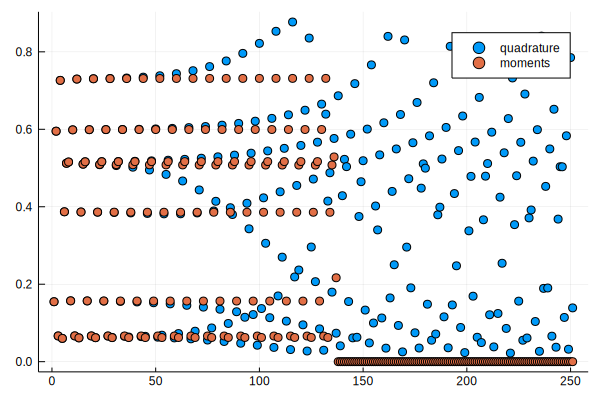

In [28]:
scatter(bxq[1,1,:];label="quadrature")
scatter!(bx[1,1,:];label="moments")

Plots for the other entries of $B_n^x$ and $B_n^y$ are similar. The quadrature and moment-based results are initially similar but start to diverge when the quadrature-based method becomes unstable. It appears that the moment-bases entries are asymptotically 8-periodic? 

Here is a plot of $\| r_n \| - 1$ for the $r_n$ generated with moments, which shows the exponential ill-conditioning of the GS-process:

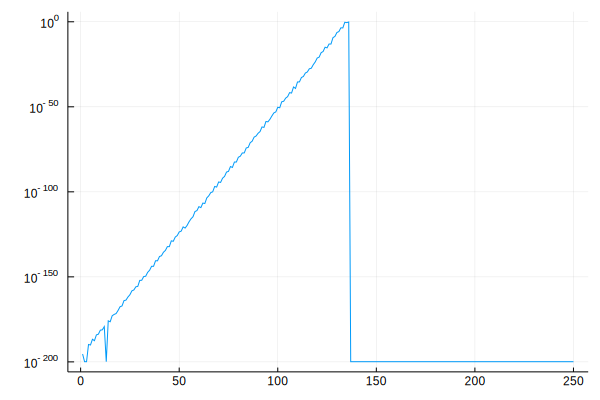

In [29]:
#plot(sv4;yscale=:log10,label="4th largest",xlabel="n")
#plot!(sv5[15:end];label="5th largest")
plot(errest.+eps(BigFloat);yscale=:log10,legend=false)
#plot!(errestq.+eps(BigFloat))

Here's a plot that suggests the $(1,1)$ entry of $B_n^x$ is asymptotically 8-periodic (this is also the case for all the other non-zero entries of $B_n^x$ and $B_n^y$).

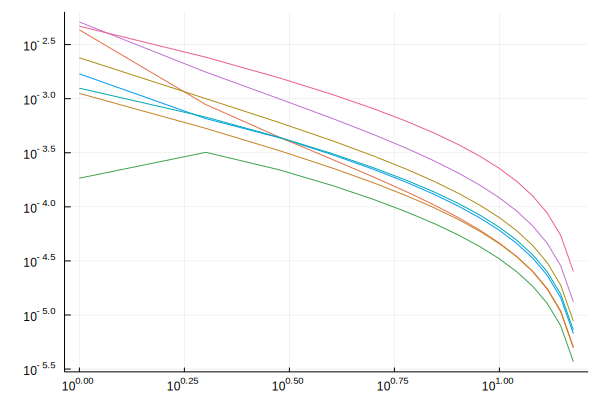

In [30]:
mind=121
p=plot(abs.(bx[1,1,1:8:mind-8].-bx[1,1,mind]);yscale=:log10,xscale=:log10,legend=false)
for k = 1:7
    plot!(abs.(bx[1,1,k+1:8:mind+k-8].-bx[1,1,mind+k]))
end
p

None of the symbols associated with the 8 matrices to which $B_n^x$ and $B_n^y$ tend for large $n$ commute or satisfy the algebraic equation:

In [31]:
symbol=(B,z)->B'/z+B*z
commute=(bx,by,z)-> symbol(bx,z)*symbol(by,z)-symbol(by,z)*symbol(bx,z)
algeq=(bx,by,z)-> symbol(bx,z)^4+symbol(by,z)^4-I;
z=1
mind=120
for k = mind-7:mind
    d1 = norm(commute(bx[:,:,k],by[:,:,k],z))
    d2 = norm(algeq(bx[:,:,k],by[:,:,k],z))
    @show d1
    @show d2
end

d1 = 1.959708519324046300622857069902124476507027142275521932320388632289041209354299203354323188502655911042235184068650907637933148665116590542863266398888613940769575398848774288615026900019238323406235651
d2 = 7.276039935124967271538503542498972168701929816800183218046863436883575662896185236397671884947170374340066854144417014136182471403397729156244159982025647866984433451104762012419429888982722299401499541
d1 = 1.964093321291585340345464220280431379604034387467908520506289525738383542007610100393445032768243437767500010927935492800283446523275033073330687811280793604604822237932197056930313589607169620551383446
d2 = 7.215014195736976914235576111619674869326998894554131998789569214504103522607048004968006551150016351955787102860748602509173986569602899180158810443484788200050586506060674522262383979221712562064937449
d1 = 1.8729584420194143668221648786716304788630516047111195545985419918980529340083320323546275845553447159143071943580242660279261064378291612844764030404446334458